# Motivation

The purpose of the marketing mix is to find the right combination of products, prices, promotions, and distribution (place) so that a company can gain and maintain an advantage over competitors. The project aims to determine the amount of promotion that is required for a product based on the total amount of stock present and also consumer sentiment. For example, if a product name Hornby 2014 Catalogue has positive sentiments based on consumer reviews as well as affordable, in the future, it will have comparatively fewer stocks than other products, so the product does not require more funds for promotion as it is already popular.on the other hand, if the same product has negative sentiment and but the price is affordable it will require funds for quality management as well as promotion. Thus by understanding the stock movement based on customer reviews and product prices we can easily determine the right combination of products, prices, promotions, and distribution (place).

# Essential libraries

In [274]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import re
import matplotlib as plt
import numpy as np
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_squared_error
import warnings

In [275]:
warnings.filterwarnings(action= 'ignore')

In [276]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Extraction and Understanding 

Data is extracted from Amazon, from where we can get all detail for a product ('product_name') such as 'manufacturer', 'price', 'number_available_in_stock' 'number_of_reviews', 'number_of_answered_questions', etc 
Our main aim is to find out the number of stock availability of a product'('number_available_in_stock',) to understand the requirement of promotion (high or low) at any time the availability of stock of a particular product is significantly less the product needs more promotion or quality improvement 


In [277]:
df=pd.read_csv("G:\\amazon_co-ecommerce_sample.csv")
df.drop_duplicates()
df.drop(['uniq_id'],axis=1,inplace=True)

In [278]:
df.head(1)

,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers
0,Hornby 2014 Catalogue,Hornby,£3.42,5 new,15,1.0,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Product Description Hornby 2014 Catalogue Box ...,Technical Details Item Weight640 g Product Dim...,Product Description Hornby 2014 Catalogue Box ...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Does this catalogue detail all the previous Ho...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ..."


# Data preprocessing 

In [279]:
#null value annalysis
def na_analysis(df):
    df_count=df.notnull().sum() #count of colloumn in the data set
    df_miss=df.isnull().sum()
    Na_annalysis=pd.concat([df_count,df_miss],axis=1,names=['mot_null','null'])
    return Na_annalysis.plot.bar(stacked=True)

## Feature Transfirmation 

Avarage Review Rateing

In [280]:
df[['average_review', 'rateing']] = df['average_review_rating'].str.split(' ', 1, expand=True) #split review
df['average_review'].astype('float64')
df.drop(['rateing','average_review_rating'],axis=1,inplace=True)

Price

In [281]:
df['price'] = df['price'].str.replace('£', '')
df['price'] = df['price'].str.replace('-', '')
df['price'] = df['price'].str.replace(',', '')
df[['price1','price2']] = df['price'].str.split(' ', 1, expand=True)
df['price1']=df['price1'].astype('float64')
df['price2']=df['price2'].astype('float64').fillna(0)
df['price_preprop']=(df['price1']+df['price2'])/2 
df.drop(['price','price1','price2'],axis=1,inplace=True)

Number of Reviews

In [282]:
df['number_of_reviews'] = df['number_of_reviews'].str.replace(',', '')
df['number_of_reviews']=df['number_of_reviews'].astype('float64')

Number if avilable stocks

In [283]:
df['number_available_in_stock'] = df['number_available_in_stock'].str.replace('new','' )
df['number_available_in_stock'] = df['number_available_in_stock'].str.replace('1\xa0used','' )
df[['number_available_in_stock','new']] = df['number_available_in_stock'].str.split(n=1, expand=True)
df.drop(['new'],axis=1,inplace=True)
df['number_available_in_stock'].astype('float64')

0        5.0
1        NaN
2        2.0
3        NaN
4        NaN
        ... 
9995     5.0
9996     NaN
9997     3.0
9998     3.0
9999    31.0
Name: number_available_in_stock, Length: 10000, dtype: float64

Features for customer sentiment.

In [284]:
df_Product_syntiment=df[['product_name', 'manufacturer','customers_who_bought_this_item_also_bought', 'description',
       'product_information', 'product_description','items_customers_buy_after_viewing_this_item','amazon_category_and_sub_category',
       'customer_questions_and_answers', 'customer_reviews', 'sellers']]
Product_review=df['average_review']

Features for stock value prediction.

In [285]:
df_Product_stock=df[['product_name','number_of_reviews','number_of_answered_questions','average_review', 'price_preprop','number_available_in_stock']]

## Na Imputation 

<AxesSubplot:>

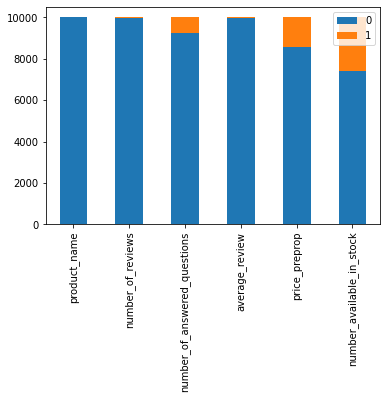

In [286]:
na_analysis(df_Product_stock)

## Na imputation strategy

Na imputation is done by business knowledge for an example if we will assume that people are not reviewing which product has a minimum number of questions to be asked by the consumer.
(the maximum frequency of 1 answered question because the particular product is not popular, so the null values are replaced by a mode of several reviews where 'df_Product_stock['number_of_answered_questions']==1')
also we find that 'number_of_answered_questions' haveing a 765 null value that will replace it by 0 assuming that no questions asked by consumers.

In [287]:
df_Product_stock['number_of_answered_questions'].fillna(0,inplace=True) #replace nun value to 0

Find out how no of reviews are dependent on the number of answered questions

<AxesSubplot:ylabel='Frequency'>

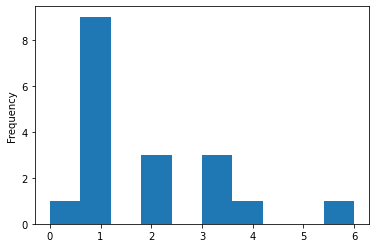

In [288]:
df_Product_stock[pd.isnull(df_Product_stock['number_of_reviews'])]['number_of_answered_questions'].astype('float64').plot.hist()

In [289]:
x=df_Product_stock[df_Product_stock['number_of_answered_questions']==1]['number_of_reviews'].mode()

In [290]:
print(f'Null numbers of reviews will be replaced by  : {x[0]}')

Null numbers of reviews will be replaced by  : 1.0


In [291]:
df_Product_stock['number_of_reviews'].fillna(1,inplace=True) 

The correlation between 'number_of_reviews','number_of_answered_questions' as follows

In [292]:
df_corr=df_Product_stock[['number_of_reviews','number_of_answered_questions']]
df_corr.corr(method='spearman')

,number_of_reviews,number_of_answered_questions
number_of_reviews,1.000000,0.052969
number_of_answered_questions,0.052969,1.000000


as they are not strongly correlated with each other we can not remove one of them

<AxesSubplot:ylabel='Frequency'>

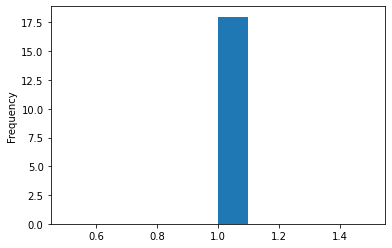

In [293]:
df_Product_stock[pd.isnull(df['average_review'])]['number_of_reviews'].astype('float64').plot.hist()

In [294]:
df_Product_stock[pd.isnull(df['average_review'])].describe()

,number_of_reviews,number_of_answered_questions,price_preprop
count,18.0,18.000000,15.000000
mean,1.0,1.888889,13.815667
std,0.0,1.450715,16.268862
min,1.0,0.000000,3.495000
25%,1.0,1.000000,5.187500
50%,1.0,1.000000,6.725000
75%,1.0,2.750000,12.985000
max,1.0,6.000000,63.475000


In [295]:
df_Product_stock[df_Product_stock['number_of_reviews']==1]['average_review'].mode()

0    5.0
dtype: object

We can not make any decision to impute null values of 'average_review' as the number of reviews is one for every null instance but having a maximum of 6 numbers of questions answered as well as the average price is relatively high, therefore we will assume that products ate in such categories are costly but not popular enough so we can replace nul values by one.

In [296]:
df_Product_stock['average_review'].fillna(1,inplace=True) 

Preprocess of price

In [297]:
df_Product_stock[pd.isnull(df['price_preprop'])]

,product_name,number_of_reviews,number_of_answered_questions,average_review,price_preprop,number_available_in_stock
9,Learning Curve Chuggington Interactive Chatsworth,8.0,1.0,4.8,NaN,1
14,Kato 3060-2 EF65 500 (F Model) Electric Locomo...,1.0,1.0,5.0,NaN,18
15,Glacier Express of N gauge 10-1219 Alps [UNESC...,1.0,1.0,5.0,NaN,12
16,Power Trains Freight Industrial (Pack of 4),2.0,1.0,4.5,NaN,2
17,Chuggington Interactive Wash and Fuel Set with...,2.0,1.0,4.0,NaN,None
...,...,...,...,...,...,...
9952,HIVE - A GAME BUZZING WITH POSSIBILITIES,2.0,1.0,5.0,NaN,1
9969,Spacegodzilla S.H.Monsterarts Action Figure,5.0,2.0,4.2,NaN,20
9976,Batman The Dark Knight Batarang Prop Replica W...,5.0,3.0,4.6,NaN,1
9983,Dc Comics Infinite Crisis Pajama Party Harley ...,2.0,3.0,5.0,NaN,5


In [298]:
#Scaleing price
P_max=df_Product_stock['price_preprop'].max()
P_min=df_Product_stock['price_preprop'].min()
print(f'maximum price of a product is {P_max} and minimmum is {P_min} thus we are takeing "price_preprop" in log scale to train the model')

maximum price of a product is 8140.3 and minimmum is 0.005 thus we are takeing "price_preprop" in log scale to train the model


In [299]:
df_Product_stock['price_preprop']=np.absolute(np.log10(df_Product_stock['price_preprop']))

In [300]:
df_Product_stock['price_preprop'].min()

0.0

Thus replaceing null values by zeros

In [301]:
df_Product_stock['price_preprop'].fillna(0,inplace=True) 

In [302]:
df_Product_stock[pd.isnull(df['price_preprop'])]

,product_name,number_of_reviews,number_of_answered_questions,average_review,price_preprop,number_available_in_stock
9,Learning Curve Chuggington Interactive Chatsworth,8.0,1.0,4.8,0.0,1
14,Kato 3060-2 EF65 500 (F Model) Electric Locomo...,1.0,1.0,5.0,0.0,18
15,Glacier Express of N gauge 10-1219 Alps [UNESC...,1.0,1.0,5.0,0.0,12
16,Power Trains Freight Industrial (Pack of 4),2.0,1.0,4.5,0.0,2
17,Chuggington Interactive Wash and Fuel Set with...,2.0,1.0,4.0,0.0,None
...,...,...,...,...,...,...
9952,HIVE - A GAME BUZZING WITH POSSIBILITIES,2.0,1.0,5.0,0.0,1
9969,Spacegodzilla S.H.Monsterarts Action Figure,5.0,2.0,4.2,0.0,20
9976,Batman The Dark Knight Batarang Prop Replica W...,5.0,3.0,4.6,0.0,1
9983,Dc Comics Infinite Crisis Pajama Party Harley ...,2.0,3.0,5.0,0.0,5


In [303]:
df_Product_stock[pd.isnull(df['number_available_in_stock'])].describe()

,number_of_reviews,number_of_answered_questions,price_preprop
count,2589.000000,2589.000000,2589.000000
mean,4.966396,1.749324,0.596439
std,22.318442,3.172909,0.511924
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.168792
50%,1.000000,1.000000,0.511215
75%,3.000000,2.000000,0.928140
max,649.000000,39.000000,3.910640


In [304]:
df_Product_stock['number_available_in_stock'].fillna(0,inplace=True) 

<AxesSubplot:>

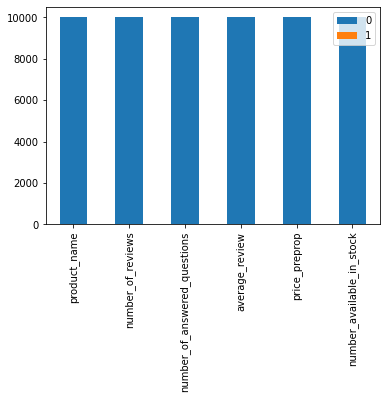

In [305]:
na_analysis(df_Product_stock)

Dependent Feature

New feature creation  Popularity compile both number_of_reviews and avarage_reviews

In [306]:
df_Product_stock['number_of_reviews']=df_Product_stock['number_of_reviews']/df_Product_stock['number_of_reviews'].max()
df_Product_stock['average_review']=df_Product_stock['average_review'].astype('float64')/df_Product_stock['average_review'].astype('float64').max()
df_Product_stock['number_of_answered_questions']= df_Product_stock['number_of_answered_questions']/df_Product_stock['number_of_answered_questions'].max()

as we find 'number_of_reviews', 'average_review', 'number_of_answered_questions' all are exclusive and independent of each other so we will prepare a feature to combine all three by multiplication

In [307]:
df_Product_stock['Prob_popularity']=df_Product_stock['number_of_reviews']*df_Product_stock['average_review']*df_Product_stock['number_of_answered_questions']

In [308]:
df_Product_stock.drop(['number_of_reviews','average_review','number_of_answered_questions'],axis=1,inplace=True)

In [310]:
df_Product_stock['Prob_popularity'].min()

0.0

<AxesSubplot:>

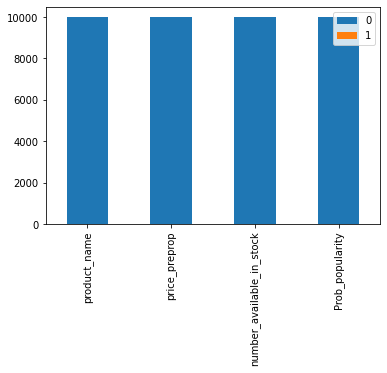

In [311]:
na_analysis(df_Product_stock)

## Prepeocess of text data

In [314]:
Review_syntement=pd.concat([df_Product_syntiment['customer_reviews'],df_Product_stock['Prob_popularity']],axis=1)
Review_syntement.dropna()

,customer_reviews,Prob_popularity
0,Worth Buying For The Pictures Alone (As Ever) ...,0.000269
1,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,0.000033
2,**Highly Recommended!** // 5.0 // 26 May 2015 ...,0.000486
3,I love it // 5.0 // 22 July 2013 // By\n \n...,0.000037
4,Birthday present // 5.0 // 14 April 2014 // By...,0.000103
...,...,...
9995,Realistic // 5.0 // 31 Mar. 2014 // By\n \n...,0.000165
9996,... what I see my grandson us going to have fu...,0.000044
9997,Five Stars // 5.0 // 18 Dec. 2015 // By\n \...,0.000055
9998,The best sculpt in a while // 5.0 // 13 May 20...,0.000055


<AxesSubplot:>

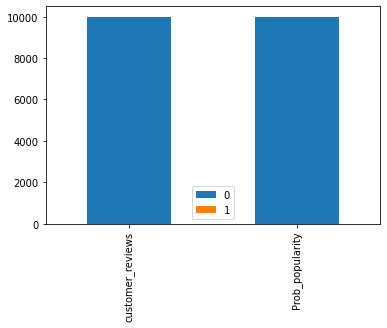

In [315]:
na_analysis(Review_syntement)

In [316]:
messages=Review_syntement['customer_reviews'].astype('str')
test=messages.to_numpy()
ps = PorterStemmer()
corpus = []
for i in range(0, len(test)):
    review = re.sub('[^a-zA-Z]', ' ', test[i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [351]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(corpus).toarray()

# Model 

In [352]:
y=Review_syntement['Prob_popularity'].to_numpy()
X = cv.fit_transform(corpus).toarray()

In [353]:
X1=df_Product_stock[['price_preprop','Prob_popularity']]
Y3=df_Product_stock['number_available_in_stock']

# Flow chart

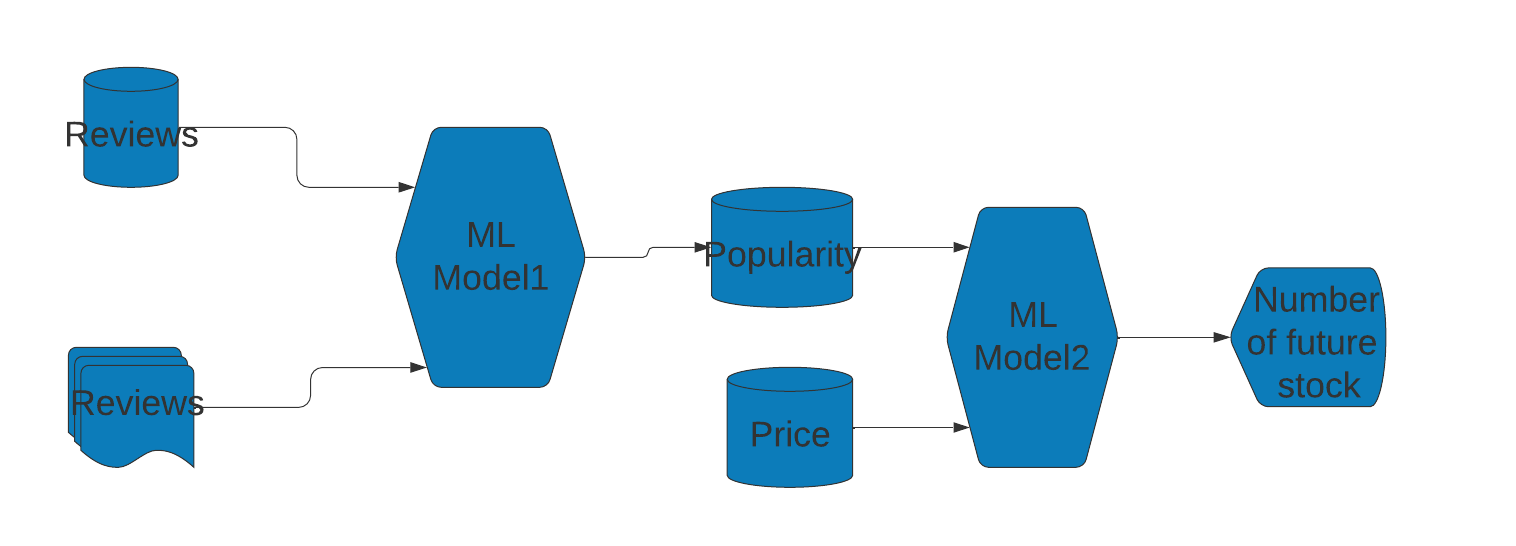

In [354]:
from IPython import display
display.Image("G:/Data bricks.png")

Data (reviews of a product) are collected From various data sources and analyzing them by a Machine learning model to predict popularity_coff. After getting the popularity_coff, and with the help of the prices of the product a 2nd machine learning model will be created that will predict the number of stock that can be left in the future, concerning the number of stock we can understand how much the product needs promotions 

In [355]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_squared_error

In [356]:
X = cv.fit_transform(corpus).toarray()
X1=df_Product_stock['price_preprop'].to_numpy()
Y3=df_Product_stock['number_available_in_stock'].to_numpy()
Y=df_Product_stock['Prob_popularity'].to_numpy()

In [357]:
Y

array([2.69423214e-04, 3.29905977e-05, 4.86061472e-04, ...,
       5.49843295e-05, 5.49843295e-05, 5.44344862e-04])

In [367]:
ML_Model_1=RandomForestRegressor(max_depth=4, random_state=0,ccp_alpha=0.05)
ML_Model_2= linear_model.TweedieRegressor(link='log', power=1)

In [368]:
X_train, X_test, Y_train, Y_test = train_test_split(X ,Y, test_size = 0.20, random_state = 0)

In [369]:
m1=ML_Model_1.fit(X_train,Y_train)
Y1=m1.predict(X_test)

In [370]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_test,Y1)

4.848194781498836e-05

In [371]:
Y1=np.asarray(Y1)

train for ML_MODEL_2

In [328]:
X1=pd.DataFrame(df_Product_stock['price_preprop'])
Y3=pd.DataFrame(df_Product_stock['number_available_in_stock'])
Y1=pd.DataFrame(Y1)

the aim of the model to prepare 'price_preprop +Y1~ number_available_in_stock

In [329]:
type(Y1)

pandas.core.frame.DataFrame

In [331]:
X_2nd_model=pd.concat([X1,Y1],axis=1)

In [332]:
X_2nd_model

,price_preprop,0
0,0.232996,0.000321
1,0.929163,0.000321
2,0.698535,0.000321
3,1.300921,0.000321
4,1.206691,0.000321
...,...,...
9995,1.059753,NaN
9996,1.300921,NaN
9997,1.342324,NaN
9998,1.396287,NaN


In [339]:
X_2nd_model=X_2nd_model.dropna()

In [340]:
X_2nd_model.min()

price_preprop    0.000000
0                0.000321
dtype: float64

In [341]:
y_2nd_model=Y3[0:2000]

In [342]:
y_2nd_model

,number_available_in_stock
0,5
1,0
2,2
3,0
4,0
...,...
1995,13
1996,3
1997,0
1998,6


In [343]:
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_2nd_model ,y_2nd_model, test_size = 0.20, random_state = 0)

In [345]:
m2=ML_Model_1.fit(X_train_1,Y_train_1)
Y2=m1.predict( X_test_1)

In [348]:
mean_poisson_deviance(Y_test_1 ,Y2)

7.147567141447232

# CONCLUSION

We can increase the performance of the model by increasing the data as well as, tuning hyperparameters, the project aims to develop a system that can predict the future stock of a product based on the popularity factor ( from customers' sentiment analysis) and price. By understanding the future stock we can estimate how much funds will be required for product promotion as well as quality improvement. With a proper plan of cash flow, we can optimize the risk of operation.